#reference

https://discuss.pytorch.org/t/using-nn-embeddingbag-with-a-cnn-in-pytorch-model/103566

https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html

https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

In [1]:
import torch
import re

## preprocess data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import sklearn as sk

In [ ]:
train_dataset = pd.read_csv('drive/MyDrive/train.csv',header=None)
test_dataset = pd.read_csv('drive/MyDrive/test.csv',header=None)

In [ ]:
for col in train_dataset.columns:
    print(col)
for col in test_dataset.columns:
    print(col)

0
1
0
1


In [ ]:
train_dataset=train_dataset.rename(columns={0: "polarity", 1: "reviews"}) 
test_dataset=test_dataset.rename(columns={0: "polarity", 1: "reviews"})

In [ ]:
train_dataset.head()

,polarity,reviews
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [ ]:
train_dataset['reviews'][0]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

In [ ]:
test_dataset.head()

,polarity,reviews
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [ ]:
train_list = train_dataset.to_records(index=False)
train_validated = list(train_list)
test_list = test_dataset.to_records(index=False)
test_validated = list(test_list)

In [ ]:
print(len(train_list))
len(test_list)

560000


38000

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
print(wnl.lemmatize("wants"))
print(wnl.lemmatize("watches"))
print(wnl.lemmatize("unhappy"))
print(wnl.lemmatize("this"))
print(wnl.lemmatize("these"))
print(wnl.lemmatize("its"))
print(wnl.lemmatize("worse"))
print(wnl.lemmatize("wants"))
print(wnl.lemmatize("don't"))
print(wnl.lemmatize("was"))
print(wnl.lemmatize("is"))

want
watch
unhappy
this
these
it
worse
want
don't
wa
is


In [ ]:
train_validated=[(i,(' '.join(map(lambda x:x if x=='was' else wnl.lemmatize(x),(re.sub(r"[^0-9a-zA-Z.,!?']+"," ",re.sub(r"\\n"," ",re.sub('(?<! )(?=[.,!?()])|(?<=[.,!?()])(?! )', r' ', j)))).split()))).lower()) for (i,j) in train_list]
print(train_validated[:2])
test_validated=[(i,(' '.join(map(lambda x:x if x=='was' else wnl.lemmatize(x),(re.sub(r"[^0-9a-zA-Z.,!?']+"," ",re.sub(r"\\n"," ",re.sub('(?<! )(?=[.,!?()])|(?<=[.,!?()])(?! )', r' ', j)))).split()))).lower()) for (i,j) in test_list]
print(test_validated[:2])

[(1, "unfortunately , the frustration of being dr . goldberg's patient is a repeat of the experience i've had with so many other doctor in nyc good doctor , terrible staff . it seems that his staff simply never answer the phone . it usually take 2 hour of repeated calling to get an answer . who ha time for that or want to deal with it ? i have run into this problem with many other doctor and i just don't get it . you have office worker , you have patient with medical need , why isn't anyone answering the phone ? it's incomprehensible and not work the aggravation . it's with regret that i feel that i have to give dr . goldberg 2 star ."), (2, "been going to dr . goldberg for over 10 year . i think i was one of his 1st patient when he started at mhmg . he's been great over the year and is really all about the big picture . it is because of him , not my now former gyn dr . markoff , that i found out i have fibroid . he explores all option with you and is very patient and understanding . h

In [4]:
import pickle
# with open('drive/MyDrive/HMX/hmx_preprocessed.pkl', 'wb') as f:  
#     pickle.dump([train_validated, test_validated], f)

# Getting back the objects:
with open('drive/MyDrive/Colab Notebooks/hmx_preprocessed2.pkl','rb') as f: 
    train_validated, test_validated = pickle.load(f)

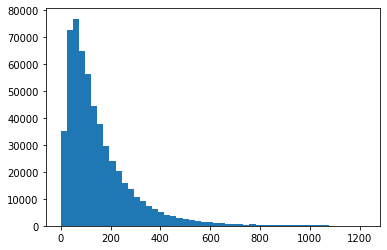

In [6]:
import matplotlib.pyplot as plt
review_lengths = []
for _,review_text in train_validated:
    review_text=review_text.split()
    review_lengths.append(len(review_text))

plt.hist(review_lengths, bins=50)
plt.show()

In [5]:
MAX_REVIEW_LENGTH = 300

def filter_output_by_length(review_text):
    return len(review_text.split()) <= MAX_REVIEW_LENGTH

In [6]:
import numpy as np
train_filtered=[]
for i,j in train_validated:
  if filter_output_by_length(j):
    train_filtered.append((i,j))

print('Dataset size BEFORE filtering: ', len(train_validated))
print('Dataset size AFTER filtering: ', len(train_filtered))
print('Number of eliminated recipes: ', len(train_validated) - len(train_filtered))

Dataset size BEFORE filtering:  560000
Dataset size AFTER filtering:  495958
Number of eliminated recipes:  64042


In [7]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_filtered), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab(['here', 'is', 'an', 'example'])

[41, 13, 65, 1936]

In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
print(text_pipeline('here is the an example'))
print(label_pipeline(10))

[41, 13, 2, 65, 1936]
9


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(train_validated, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [10]:
from torch import nn
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.conv1 = nn.Sequential(  #define the model
            nn.Conv1d(in_channels=embed_dim, out_channels=16, kernel_size=1),     #16 features, see each word
            nn.ReLU()                                                             #convert negative to 0
        )
        self.fc = nn.Linear(16, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        # self.fc.bias.data.zero_()

    def forward(self, text, offsets):
      #good luck, i dont know
        x = self.embedding(text, offsets).unsqueeze(2)
        x = self.conv1(x)
        x = x.view(-1, 16)
        x = self.fc(x)
        return x

In [ ]:
len(vocab)

164494

In [13]:
num_class = len(set([label for (label, text) in train_validated]))
print(num_class)

2


In [14]:
vocab_size = len(vocab)
emsize = 100
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [11]:

import time
from tqdm import tqdm
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in tqdm(enumerate(dataloader)):#iterate through all dataloader base on batch size
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label) #calc cross entropy loss
        loss.backward() #backward propgation, modify embedding, fc, 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step() #update everything
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)# calc accuracy
        if idx % log_interval == 0 and idx > 0:#print accuracy
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            print('train loss',loss)
            total_acc, total_count = 0, 0
            start_time = time.time()
    return total_acc/total_count,loss

def evaluate(dataloader):
    model.eval()#set eval mode, will not change weight embedding
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count,loss

In [15]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 250 # batch size for training
#set up models
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_filtered)
test_dataset = to_map_style_dataset(test_validated)
num_train = int(len(train_dataset) * 0.95)# train95%, and validate 5%, validation to prevent overfit
split_train_, split_valid_ =  random_split(train_dataset, [num_train, len(train_dataset) - num_train])

#load data, randomize all the epoch
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [ ]:
valAcc=[]
trainAcc=[]
valLoss=[]
trainLoss=[]

for epoch in range(1, EPOCHS + 1):
    #print(epoch,epoch.dtype)
    
    epoch_start_time = time.time()
    accu_train,loss_train=train(train_dataloader)
    accu_val,loss_val = evaluate(valid_dataloader)
    valAcc.append(accu_val)
    trainAcc.append(accu_train)
    valLoss.append(loss_val)
    trainLoss.append(loss_train)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    torch.save(model, 'drive/MyDrive/Colab Notebooks/lastcnn'+str(epoch)+'.pkl')
    print('-' * 59)

503it [00:33, 14.35it/s]

| epoch   1 |   500/ 1885 batches | train accuracy    0.681
train loss tensor(0.4848, grad_fn=<NllLossBackward>)


1003it [01:06, 15.12it/s]

| epoch   1 |  1000/ 1885 batches | train accuracy    0.817
train loss tensor(0.3687, grad_fn=<NllLossBackward>)


1503it [01:39, 14.85it/s]

| epoch   1 |  1500/ 1885 batches | train accuracy    0.854
train loss tensor(0.3566, grad_fn=<NllLossBackward>)


1885it [02:04, 15.16it/s]


-----------------------------------------------------------
| end of epoch   1 | time: 126.59s | valid accuracy    0.871 
-----------------------------------------------------------


503it [00:34, 14.93it/s]

| epoch   2 |   500/ 1885 batches | train accuracy    0.876
train loss tensor(0.3338, grad_fn=<NllLossBackward>)


1003it [01:07, 14.46it/s]

| epoch   2 |  1000/ 1885 batches | train accuracy    0.884
train loss tensor(0.2584, grad_fn=<NllLossBackward>)


1503it [01:40, 16.21it/s]

| epoch   2 |  1500/ 1885 batches | train accuracy    0.890
train loss tensor(0.2600, grad_fn=<NllLossBackward>)


1885it [02:05, 15.05it/s]


-----------------------------------------------------------
| end of epoch   2 | time: 127.55s | valid accuracy    0.897 
-----------------------------------------------------------


503it [00:33, 15.18it/s]

| epoch   3 |   500/ 1885 batches | train accuracy    0.898
train loss tensor(0.2501, grad_fn=<NllLossBackward>)


1003it [01:06, 15.33it/s]

| epoch   3 |  1000/ 1885 batches | train accuracy    0.899
train loss tensor(0.2520, grad_fn=<NllLossBackward>)


1503it [01:39, 14.59it/s]

| epoch   3 |  1500/ 1885 batches | train accuracy    0.901
train loss tensor(0.2939, grad_fn=<NllLossBackward>)


1885it [02:04, 15.14it/s]


-----------------------------------------------------------
| end of epoch   3 | time: 126.81s | valid accuracy    0.906 
-----------------------------------------------------------


503it [00:33, 14.92it/s]

| epoch   4 |   500/ 1885 batches | train accuracy    0.906
train loss tensor(0.2571, grad_fn=<NllLossBackward>)


1003it [01:06, 15.19it/s]

| epoch   4 |  1000/ 1885 batches | train accuracy    0.908
train loss tensor(0.1826, grad_fn=<NllLossBackward>)


1503it [01:39, 14.96it/s]

| epoch   4 |  1500/ 1885 batches | train accuracy    0.909
train loss tensor(0.2248, grad_fn=<NllLossBackward>)


1885it [02:04, 15.18it/s]


-----------------------------------------------------------
| end of epoch   4 | time: 126.38s | valid accuracy    0.917 
-----------------------------------------------------------


503it [00:33, 15.91it/s]

| epoch   5 |   500/ 1885 batches | train accuracy    0.911
train loss tensor(0.2069, grad_fn=<NllLossBackward>)


1003it [01:05, 15.77it/s]

| epoch   5 |  1000/ 1885 batches | train accuracy    0.912
train loss tensor(0.2128, grad_fn=<NllLossBackward>)


1503it [01:38, 15.56it/s]

| epoch   5 |  1500/ 1885 batches | train accuracy    0.912
train loss tensor(0.1925, grad_fn=<NllLossBackward>)


1885it [02:03, 15.23it/s]


-----------------------------------------------------------
| end of epoch   5 | time: 126.04s | valid accuracy    0.917 
-----------------------------------------------------------


503it [00:33, 15.67it/s]

| epoch   6 |   500/ 1885 batches | train accuracy    0.915
train loss tensor(0.1886, grad_fn=<NllLossBackward>)


1003it [01:06, 14.84it/s]

| epoch   6 |  1000/ 1885 batches | train accuracy    0.915
train loss tensor(0.1707, grad_fn=<NllLossBackward>)


1503it [01:39, 15.79it/s]

| epoch   6 |  1500/ 1885 batches | train accuracy    0.915
train loss tensor(0.1906, grad_fn=<NllLossBackward>)


1885it [02:05, 15.07it/s]


-----------------------------------------------------------
| end of epoch   6 | time: 127.33s | valid accuracy    0.909 
-----------------------------------------------------------


503it [00:33, 14.55it/s]

| epoch   7 |   500/ 1885 batches | train accuracy    0.930
train loss tensor(0.1556, grad_fn=<NllLossBackward>)


1003it [01:05, 15.51it/s]

| epoch   7 |  1000/ 1885 batches | train accuracy    0.929
train loss tensor(0.2231, grad_fn=<NllLossBackward>)


1503it [01:38, 15.39it/s]

| epoch   7 |  1500/ 1885 batches | train accuracy    0.930
train loss tensor(0.2008, grad_fn=<NllLossBackward>)


1885it [02:03, 15.30it/s]


-----------------------------------------------------------
| end of epoch   7 | time: 125.44s | valid accuracy    0.931 
-----------------------------------------------------------


503it [00:33, 15.61it/s]

| epoch   8 |   500/ 1885 batches | train accuracy    0.931
train loss tensor(0.1813, grad_fn=<NllLossBackward>)


1003it [01:05, 15.32it/s]

| epoch   8 |  1000/ 1885 batches | train accuracy    0.929
train loss tensor(0.1897, grad_fn=<NllLossBackward>)


1503it [01:38, 15.22it/s]

| epoch   8 |  1500/ 1885 batches | train accuracy    0.931
train loss tensor(0.2763, grad_fn=<NllLossBackward>)


1885it [02:03, 15.27it/s]


-----------------------------------------------------------
| end of epoch   8 | time: 125.63s | valid accuracy    0.931 
-----------------------------------------------------------


503it [00:33, 16.08it/s]

| epoch   9 |   500/ 1885 batches | train accuracy    0.930
train loss tensor(0.1661, grad_fn=<NllLossBackward>)


1003it [01:05, 15.00it/s]

| epoch   9 |  1000/ 1885 batches | train accuracy    0.931
train loss tensor(0.2392, grad_fn=<NllLossBackward>)


1503it [01:38, 15.38it/s]

| epoch   9 |  1500/ 1885 batches | train accuracy    0.931
train loss tensor(0.1521, grad_fn=<NllLossBackward>)


1885it [02:03, 15.32it/s]


-----------------------------------------------------------
| end of epoch   9 | time: 125.31s | valid accuracy    0.932 
-----------------------------------------------------------


503it [00:33, 15.84it/s]

| epoch  10 |   500/ 1885 batches | train accuracy    0.931
train loss tensor(0.1172, grad_fn=<NllLossBackward>)


1003it [01:05, 16.48it/s]

| epoch  10 |  1000/ 1885 batches | train accuracy    0.932
train loss tensor(0.1373, grad_fn=<NllLossBackward>)


1503it [01:38, 15.23it/s]

| epoch  10 |  1500/ 1885 batches | train accuracy    0.931
train loss tensor(0.2050, grad_fn=<NllLossBackward>)


1885it [02:03, 15.30it/s]


-----------------------------------------------------------
| end of epoch  10 | time: 125.53s | valid accuracy    0.931 
-----------------------------------------------------------


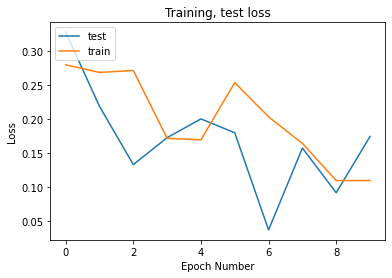

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training, test loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(valLoss,label='test')
plt.plot(trainLoss,label='train')
#plt.plot(Val_loss,label='validation')
plt.plot()
plt.legend(loc='upper left')

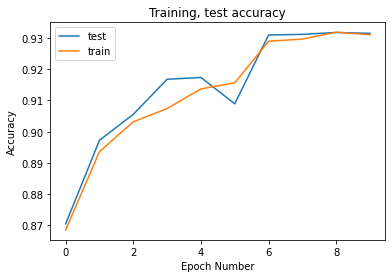

In [ ]:
plt.title('Training, test accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(valAcc,label='test')
plt.plot(trainAcc,label='train')
#plt.plot(Val_loss,label='validation')
plt.plot()
plt.legend(loc='upper left')

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print(accu_test)

Checking the results of test dataset.
(0.9328684210526316, tensor(0.1745))


In [47]:
reviews_label = {1: "Negative",
                 2: "Positive"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        print(output)
        return output.argmax(1).item() + 1


ex_text_str = ["Have had 4 rescheduled appointments for connection of NBN which I have taken work off to attend because the technician hasn't come. Every time I call NBN after the 4 hour window to ask if anyone is coming, I'm told to wait as someone will come by the end of the day. No one shows up and my whole day is wasted. It's gone past the point of frustration and this level of service is just embarrassing."]

model = model.to("cpu")




for i in range(len(ex_text_str)):
  print(ex_text_str[i][0:40]+"......       is a %s reviews" %reviews_label[predict(ex_text_str[i], text_pipeline)])

tensor([[ 1.3067, -1.5098]])
Have had 4 rescheduled appointments for ......       is a Negative reviews


In [16]:
model=torch.load('drive/MyDrive/Colab Notebooks/lastcnn10.pkl')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=collate_batch)

In [43]:

Predict=[[],[]]
with torch.no_grad():
        model.eval()
        model.to(device)

        for j,(target,data,offset) in enumerate(test_dataloader):   
            data = data.to(device)
            target = target.long().to(device)
            #print(target)
            offset=offset.long().to(device)
            outputs = model(data,offset)
            predict = outputs
            _, predicted = torch.max(outputs.data, 1)
            #print(predict.shape)
            #print(predicted)
            for i in range(250):
              if predicted[i]!=target[i]:
                #print(predict[i].max())
                Predict[target[i]].append((j,i,predict[i].max(),predict[i]))
        

In [68]:
print(len(Predict[1]))

1217


In [44]:
#find max
softmaxneg=[]
for i in range(len(Predict[0])):
  #print(Predict[0][i][2])
  softmaxneg.append(Predict[0][i][2].data.tolist())
#print(softmax[0:10])
a=sorted(range(len(softmaxneg)), key=lambda i: softmaxneg[i])[-10:]
print(a)

for i in a:
  print(test_dataset[(Predict[0][i][0])*250+Predict[0][i][1]])
  print(' predicted ',Predict[0][i][3])

softmaxpos=[]
for i in range(len(Predict[1])):
  #print(Predict[0][i][2])
  softmaxpos.append(Predict[1][i][2].data.tolist())
#print(softmax[0:10])
a=sorted(range(len(softmaxpos)), key=lambda i: softmaxpos[i])[-5:]


for i in a:
  print(test_dataset[(Predict[1][i][0])*250+Predict[1][i][1]])
  print(' label ',Predict[1][i][3])


[463, 1264, 624, 112, 1060, 1251, 694, 1067, 905, 814]
(1, 'this place made me wish i had a magic carpet and could at the exact moment i escalated in , teleport back to san francisco . booooooooooooooooooooooo')
 predicted  tensor([-2.7596,  2.9961])
(1, "get the concrete mixer , you'll love it ! other than that , it's fast food .")
 predicted  tensor([-2.9805,  3.0117])
(1, "for the price , this is a great option . clean , comfortable , modern , awesome location and fantastic guest service . free wifi , decent gym . i really love the outdoor fire pit the menu at the restaurant ha an outstanding selection . warning ! ! a huge disappointment ! ! while traveling for business , where my sleep is imperative , i was quickly disturbed with the obnoxious volume and thump coming from the adjacent night club . this was on a was even on a tuesday night ! ! i can only imagine a weekend noise level ! so intrusive . so upsetting . can't stay here again because of this")
 predicted  tensor([-2.8551,

In [ ]:
# from torch import nn
# m = nn.Conv1d(16, 33, 3, stride=2)
# input = torch.randn(20, 16, 50)
# len(m(input)[0])

33